In [1]:

import time

import torch

from scipy.stats import spearmanr

from sjlt_cuda import SJLTProjection

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# First, check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [2]:
def compute_pairwise_distance_metrics(grad_t, grad_p):
    """
    Computes relative error, RMSE, and stress between pairwise distances of
    original and projected datasets.

    Arguments:
    grad_t -- tensor of original data (batch of gradients)
    grad_p -- tensor of projected data (batch of projected gradients)

    Returns:
    relative_error -- average relative error between original and projected pairwise distances
    rmse -- root mean squared error between original and projected pairwise distances
    stress -- stress function measuring global distance preservation
    """

    # Compute pairwise distances
    original_distances = torch.cdist(grad_t, grad_t, p=2)
    projected_distances = torch.cdist(grad_p, grad_p, p=2)

    # Avoid division by zero for any zero distances in the original data
    mask = original_distances > 1e-8  # Mask to filter out zero distances

    # Compute Relative Error
    relative_errors = torch.abs((original_distances[mask] - projected_distances[mask]) / original_distances[mask])
    average_relative_error = torch.mean(relative_errors).item()

    # Compute RMSE (Root Mean Squared Error)
    # mse = torch.mean((original_distances[mask] - projected_distances[mask]) ** 2)
    # rmse = torch.sqrt(mse).item()

    # Compute Stress
    # stress = torch.sqrt(torch.sum((original_distances[mask] - projected_distances[mask]) ** 2) /
    #                     torch.sum(original_distances[mask] ** 2)).item()

    return average_relative_error#, rmse, stress

def compute_pairwise_inner_product_rank_correlation(grad_t, grad_p):
    """
    Computes Spearman's rank correlation coefficient for pairwise inner products
    between original and projected datasets.

    Arguments:
    grad_t -- tensor of original data (batch of gradients)
    grad_p -- tensor of projected data (batch of projected gradients)

    Returns:
    spearman_corr -- Spearman's rank correlation coefficient
    """

    # Compute pairwise inner products (original and projected)
    original_inner_products = torch.matmul(grad_t, grad_t.T).flatten()
    projected_inner_products = torch.matmul(grad_p, grad_p.T).flatten()

    # Convert tensors to numpy arrays for rank calculation
    original_inner_products_np = original_inner_products.cpu().numpy()
    projected_inner_products_np = projected_inner_products.cpu().numpy()

    # Compute Spearman's rank correlation
    spearman_corr, _ = spearmanr(original_inner_products_np, projected_inner_products_np)

    return spearman_corr

In [3]:
data_type = torch.float32

def benchmark(batch_size, original_dim,  projection_dims, sparsity_levels, device, include_gaussian=True):
    """
    Compare Gaussian, vanilla SJLT, and CUDA SJLT projection methods across different sparsity levels.

    Parameters:
    -----------
    projection_dims : list
        List of projection dimensions to test
    sparsity_levels : list
        List of sparsity levels to test (0.0 to 1.0)
    device : str
        Device to use for computation ("cuda" or "cpu")
    include_gaussian : bool, default=True
        Whether to include Gaussian projection in the comparison (set to False to avoid OOM errors for large dimensions)

    Returns:
    --------
    dict
        Dictionary containing all results
    """
    # Results dictionaries
    results = {
        "sjlt": {
            "times": {sparsity: [] for sparsity in sparsity_levels},
            "relative_errors": {sparsity: [] for sparsity in sparsity_levels}
        },
        "sjlt_cuda": {
            "times": {sparsity: [] for sparsity in sparsity_levels},
            "relative_errors": {sparsity: [] for sparsity in sparsity_levels}
        }
    }

    # Add Gaussian results dict only if we're including it
    if include_gaussian:
        results["gaussian"] = {
            "times": {sparsity: [] for sparsity in sparsity_levels},
            "relative_errors": {sparsity: [] for sparsity in sparsity_levels}
        }

    # Create a batch of vectors
    batch_vec = torch.randn(batch_size, original_dim, device=device, dtype=data_type)

    # Backup original vectors
    batch_vec_clone = batch_vec.clone()

    # SJLT parameters
    c = 1

    for proj_dim in projection_dims:
        print(f"Processing projection dimension: {proj_dim}")

        # For Gaussian projection - only create if needed
        if include_gaussian:
            try:
                gaussian_matrix = torch.randn(proj_dim, original_dim, device=device, dtype=data_type) / (proj_dim ** 0.5)
            except RuntimeError as e:
                if "out of memory" in str(e).lower():
                    print(f"  WARNING: OOM error when creating Gaussian matrix for dim={proj_dim}.")
                    print(f"  Disabling Gaussian comparison for this and larger dimensions.")
                    include_gaussian = False  # Disable for future iterations
                else:
                    raise  # Re-raise if it's not an OOM error

        # For SJLT projection
        rand_indices = torch.randint(proj_dim, (original_dim, c), device=device, dtype=torch.int32)
        rand_signs = torch.randint(0, 2, (original_dim, c), device=device, dtype=torch.int32) * 2 - 1

        # Initialize CUDA SJLT module
        sjlt_cuda_module = SJLTProjection(original_dim, proj_dim, c, device=device)
        # Make sure it uses the same random indices and signs for fair comparison
        sjlt_cuda_module.rand_indices.copy_(rand_indices)
        sjlt_cuda_module.rand_signs.copy_((rand_signs.to(torch.int8)))

        for sparsity in sparsity_levels:
            print(f"  Sparsity level: {sparsity}")
            batch_vec = batch_vec_clone.clone()

            # Sparsify the vectors by randomly setting a fraction (sparsity) of elements to zero
            if sparsity > 0:
                num_elements_to_drop = int(sparsity * original_dim)
                for i in range(batch_size):
                    indices_to_drop = torch.randperm(original_dim, device=device)[:num_elements_to_drop]
                    batch_vec[i, indices_to_drop] = 0

            # --- Gaussian Projection ---
            if include_gaussian:
                try:
                    # Cold Start once to avoid overhead
                    batch_vec_gaussian = batch_vec @ gaussian_matrix.T

                    # Time the Gaussian projection
                    torch.cuda.synchronize(device)
                    start_time = time.time()

                    # Perform Gaussian projection
                    batch_vec_gaussian = batch_vec @ gaussian_matrix.T

                    torch.cuda.synchronize(device)
                    gaussian_time = time.time() - start_time

                    # Calculate relative error for Gaussian
                    gaussian_error = compute_pairwise_distance_metrics(batch_vec, batch_vec_gaussian)

                    # Store results
                    results["gaussian"]["times"][sparsity].append(gaussian_time)
                    results["gaussian"]["relative_errors"][sparsity].append(gaussian_error)

                except RuntimeError as e:
                    if "out of memory" in str(e).lower():
                        print(f"  WARNING: OOM error during Gaussian projection for dim={proj_dim}, sparsity={sparsity}.")
                        print(f"  Disabling Gaussian comparison for this and larger dimensions.")
                        include_gaussian = False  # Disable for future iterations

                        # Add None values to maintain consistency in results
                        if "gaussian" in results:
                            results["gaussian"]["times"][sparsity].append(None)
                            results["gaussian"]["relative_errors"][sparsity].append(None)
                    else:
                        raise  # Re-raise if it's not an OOM error

            # --- SJLT Projection (PyTorch implementation) ---

            # Cold Start once to avoid overhead
            batch_size, _ = batch_vec.size()

            # Get indices of elements above 0 in a single pass
            batch_idx, input_idx = torch.nonzero(torch.abs(batch_vec) > 0, as_tuple=True)
            values = batch_vec[batch_idx, input_idx]

            scaled_vals = values.repeat_interleave(c) * rand_signs[input_idx].flatten()
            final_indices = batch_idx.repeat_interleave(c) * proj_dim + rand_indices[input_idx].flatten()

            # Initialize and fill output tensor
            batch_vec_sjlt = torch.zeros(batch_size, proj_dim, device=device, dtype=data_type)
            batch_vec_sjlt.view(-1).index_add_(0, final_indices, scaled_vals)

            # Sum and normalize
            batch_vec_sjlt = batch_vec_sjlt.view(batch_size, proj_dim) / (c ** 0.5)

            # Time the SJLT projection
            torch.cuda.synchronize(device)
            start_time = time.time()

            # Perform SJLT projection
            batch_size, _ = batch_vec.size()

            # Get indices of elements above 0 in a single pass
            batch_idx, input_idx = torch.nonzero(torch.abs(batch_vec) > 0, as_tuple=True)
            values = batch_vec[batch_idx, input_idx]

            scaled_vals = values.repeat_interleave(c) * rand_signs[input_idx].flatten()
            final_indices = batch_idx.repeat_interleave(c) * proj_dim + rand_indices[input_idx].flatten()

            # Initialize and fill output tensor
            batch_vec_sjlt = torch.zeros(batch_size, proj_dim, device=device, dtype=data_type)
            batch_vec_sjlt.view(-1).index_add_(0, final_indices, scaled_vals)

            # Sum and normalize
            batch_vec_sjlt = batch_vec_sjlt.view(batch_size, proj_dim) / (c ** 0.5)

            torch.cuda.synchronize(device)
            sjlt_time = time.time() - start_time

            # Calculate relative error for SJLT
            sjlt_error = compute_pairwise_distance_metrics(batch_vec, batch_vec_sjlt)

            # Store results
            results["sjlt"]["times"][sparsity].append(sjlt_time)
            results["sjlt"]["relative_errors"][sparsity].append(sjlt_error)

            # --- SJLT CUDA Projection ---

            # Cold Start once to avoid overhead
            with torch.no_grad():
                batch_vec_sjlt_cuda = sjlt_cuda_module(batch_vec)

            # Time the CUDA SJLT projection
            torch.cuda.synchronize(device)
            start_time = time.time()

            # Perform CUDA SJLT projection
            with torch.no_grad():
                batch_vec_sjlt_cuda = sjlt_cuda_module(batch_vec)

            torch.cuda.synchronize(device)
            sjlt_cuda_time = time.time() - start_time

            # Calculate relative error for CUDA SJLT
            sjlt_cuda_error = compute_pairwise_distance_metrics(batch_vec, batch_vec_sjlt_cuda)

            # Store results
            results["sjlt_cuda"]["times"][sparsity].append(sjlt_cuda_time)
            results["sjlt_cuda"]["relative_errors"][sparsity].append(sjlt_cuda_error)

            # Verify that both SJLT implementations give similar results
            diff = torch.abs(batch_vec_sjlt - batch_vec_sjlt_cuda).max().item()
            print(f"    Max difference between PyTorch and CUDA SJLT: {diff:.6f}")

    return results

In [4]:
def plot_benchmark(results, projection_dims, sparsity_levels, log_scale=True):
    """
    Plot the comparison results between Gaussian, SJLT, and CUDA SJLT projection methods.

    Parameters:
    -----------
    results : dict
        Dictionary containing all results
    projection_dims : list
        List of projection dimensions tested
    sparsity_levels : list
        List of sparsity levels tested
    log_scale : bool, default=True
        Whether to use a logarithmic scale for the y-axis
    """
    colors = {
        "SJLT": 'dodgerblue',
        "Gaussian": 'orange',
        "SJLT_CUDA": 'forestgreen'  # New color for CUDA SJLT
    }

    # Define line styles and markers for better visual distinction
    linestyles = {
        "SJLT": '--',
        "Gaussian": '-',
        "SJLT_CUDA": '-.'  # Dash-dot for CUDA SJLT
    }

    markers = {
        "SJLT": 'x',
        "Gaussian": 'o',
        "SJLT_CUDA": 's'  # Square marker for CUDA SJLT
    }

    # Reverse opacity: higher sparsity = more transparent
    min_alpha = 0.3
    max_alpha = 1.0
    sorted_sparsity = sorted(sparsity_levels)
    alphas = {
        s: max_alpha - i / max(1, len(sparsity_levels)-1) * (max_alpha - min_alpha)
        for i, s in enumerate(sorted_sparsity)
    }

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

    # Check if Gaussian results exist
    include_gaussian = "gaussian" in results

    # --- Plot 1: Computational Time ---
    ax = axes[0]
    for sparsity in sparsity_levels:
        alpha = alphas[sparsity]

        # Gaussian (if available)
        if include_gaussian:
            # Filter out None values that might be present due to OOM errors
            valid_dims = []
            valid_times = []
            for i, t in enumerate(results["gaussian"]["times"][sparsity]):
                if t is not None and i < len(projection_dims):
                    valid_dims.append(projection_dims[i])
                    valid_times.append(t)

            if valid_dims:  # Only plot if there's data
                ax.plot(valid_dims, valid_times,
                        marker=markers["Gaussian"], linestyle=linestyles["Gaussian"],
                        linewidth=1, markersize=4,
                        color=colors["Gaussian"], alpha=alpha)

        # SJLT (PyTorch)
        ax.plot(projection_dims, results["sjlt"]["times"][sparsity],
                marker=markers["SJLT"], linestyle=linestyles["SJLT"],
                linewidth=1, markersize=4,
                color=colors["SJLT"], alpha=alpha)

        # SJLT (CUDA)
        ax.plot(projection_dims, results["sjlt_cuda"]["times"][sparsity],
                marker=markers["SJLT_CUDA"], linestyle=linestyles["SJLT_CUDA"],
                linewidth=1, markersize=4,
                color=colors["SJLT_CUDA"], alpha=alpha)

    ax.set_title("Computational Time by Projection Dimension")
    ax.set_xlabel("Projection Dimension")
    ax.set_ylabel("Time (s)")
    ax.set_xticks(projection_dims)
    ax.tick_params(axis='both', which='major')
    # ax.grid(True, alpha=0.3)

    # Set y-axis to log scale if requested
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')
        # ax.grid(True, alpha=0.3, which='both')  # Grid lines for both major and minor ticks

    # --- Plot 2: Relative Error ---
    ax = axes[1]
    for sparsity in sparsity_levels:
        alpha = alphas[sparsity]

        # Gaussian (if available)
        if include_gaussian:
            # Filter out None values that might be present due to OOM errors
            valid_dims = []
            valid_errors = []
            for i, e in enumerate(results["gaussian"]["relative_errors"][sparsity]):
                if e is not None and i < len(projection_dims):
                    valid_dims.append(projection_dims[i])
                    valid_errors.append(e)

            if valid_dims:  # Only plot if there's data
                ax.plot(valid_dims, valid_errors,
                        marker=markers["Gaussian"], linestyle=linestyles["Gaussian"],
                        linewidth=1, markersize=4,
                        color=colors["Gaussian"], alpha=alpha)

        # SJLT (PyTorch)
        ax.plot(projection_dims, results["sjlt"]["relative_errors"][sparsity],
                marker=markers["SJLT"], linestyle=linestyles["SJLT"],
                linewidth=1, markersize=4,
                color=colors["SJLT"], alpha=alpha)

        # SJLT (CUDA)
        ax.plot(projection_dims, results["sjlt_cuda"]["relative_errors"][sparsity],
                marker=markers["SJLT_CUDA"], linestyle=linestyles["SJLT_CUDA"],
                linewidth=1, markersize=4,
                color=colors["SJLT_CUDA"], alpha=alpha)

    ax.set_title("Relative Error by Projection Dimension")
    ax.set_xlabel("Projection Dimension")
    ax.set_ylabel("Relative Error")
    ax.set_xticks(projection_dims)
    ax.tick_params(axis='both', which='major')
    # ax.grid(True, alpha=0.3)

    # Set y-axis to log scale if requested
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')
        # ax.grid(True, alpha=0.3, which='both')  # Grid lines for both major and minor ticks

    # --- Unified Legend ---
    # Line style & color legend (Gaussian vs SJLT vs CUDA SJLT)
    method_handles = [
        Line2D([0], [0], linestyle=linestyles["SJLT"], color=colors["SJLT"],
               marker=markers["SJLT"], linewidth=1, label='Sparse (PyTorch)'),
        Line2D([0], [0], linestyle=linestyles["SJLT_CUDA"], color=colors["SJLT_CUDA"],
               marker=markers["SJLT_CUDA"], linewidth=1, label='Sparse (CUDA)')
    ]

    # Add Gaussian to legend only if it's included in results
    if include_gaussian:
        method_handles.insert(0,
            Line2D([0], [0], linestyle=linestyles["Gaussian"], color=colors["Gaussian"],
                   marker=markers["Gaussian"], linewidth=1, label='Dense (Gaussian)')
        )

    # Opacity-based legend for sparsity levels
    sparsity_handles = [
        Line2D([0], [0], linestyle='-', color='gray', alpha=alphas[s],
               linewidth=1, label=f'Sparsity={s}')
        for s in sparsity_levels
    ]

    all_handles = method_handles + sparsity_handles
    fig.legend(handles=all_handles, loc='lower center',
               ncol=len(method_handles) + len(sparsity_levels),  # Adjusted number of columns
               bbox_to_anchor=(0.5, 0.07))

    plt.tight_layout(rect=[0, 0.12, 1, 1])  # Adjusted to make room for legend

Processing projection dimension: 32
  Sparsity level: 0
    Max difference between PyTorch and CUDA SJLT: 0.015900
  Sparsity level: 0.1
    Max difference between PyTorch and CUDA SJLT: 0.018738
  Sparsity level: 0.3
    Max difference between PyTorch and CUDA SJLT: 0.011108
  Sparsity level: 0.5
    Max difference between PyTorch and CUDA SJLT: 0.007385
  Sparsity level: 0.7
    Max difference between PyTorch and CUDA SJLT: 0.005737
  Sparsity level: 0.9
    Max difference between PyTorch and CUDA SJLT: 0.002014
Processing projection dimension: 64
  Sparsity level: 0
    Max difference between PyTorch and CUDA SJLT: 0.012451
  Sparsity level: 0.1
    Max difference between PyTorch and CUDA SJLT: 0.008728
  Sparsity level: 0.3
    Max difference between PyTorch and CUDA SJLT: 0.005920
  Sparsity level: 0.5
    Max difference between PyTorch and CUDA SJLT: 0.006348
  Sparsity level: 0.7
    Max difference between PyTorch and CUDA SJLT: 0.002747
  Sparsity level: 0.9
    Max difference 

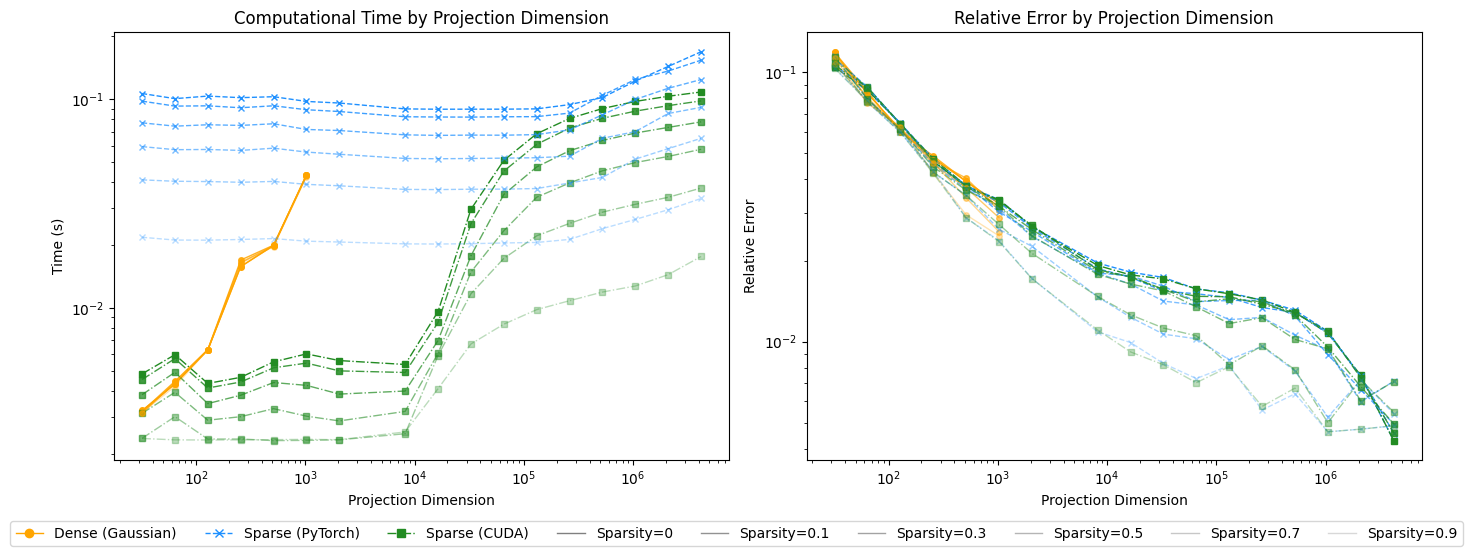

In [5]:
batch_size = 64
original_dim = 4194304
projection_dims = [32, 64, 128, 256, 512, 1024, 2048, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304]
sparsity_levels = [0, 0.1, 0.3, 0.5, 0.7, 0.9]

results = benchmark(batch_size, original_dim, projection_dims, sparsity_levels, device, include_gaussian=True)
plot_benchmark(results, projection_dims, sparsity_levels)